# Ensemble Learning

The intuition is to combine different classifiers into a meta-classifier that has a better performance than any individual classifier alone.

## Majority Vote Concept

The concept of weighted majority vote.   
3 Classifier classifies this observation as class [ 0, 0, 1 ] respectively. If the weight of these 3 classifiers are [ 0.2, 0.2, 0.6 ] then this observation will be classified as class 1. 

In [2]:
# assign a list of weight, whose shape is equivalent to x
np.argmax( np.bincount( [ 0, 0, 1 ], weights = [ 0.2, 0.2, 0.6 ] ) )

1

When class becomes probability ( probability of being classified as class 0 and class1 ).

In [3]:
ex = np.array( [ [ 0.9, 0.1 ], [ 0.8, 0.2 ], [ 0.4, 0.6 ] ] )
p = np.average( ex, axis = 0, weights = [ 0.2, 0.2, 0.6 ] )
print(p)
print( np.argmax(p) )

[ 0.58  0.42]
0


## Preparing the Dataset and Algorithm

In [4]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
import numpy as np

Load iris data. Use only two of the features and work on classifying two classes.

In [5]:
iris = datasets.load_iris()
X, y = iris.data[ 50:, [1, 2] ], iris.target[50:]
le = LabelEncoder()
y  = le.fit_transform(y)

# split the data into 50% training / 50% testing
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.5, random_state = 1 )

Train three different classifiers : 1) logistic regression ; 2) decision tree ; 3) k nearest neighbors. Look at their individual performance via a 10 fold cross-validation before combining them into an emsemble classifer.

Note that unlike tree-base algorithms, logistic regression and k nearest neighbors are not scale-invariant, thus it's a good habit to work with standardized features ( use a Pipeline ).

In [6]:
clf1 = LogisticRegression( penalty = 'l2', 
                           C = 0.001, 
                           random_state = 0 )

clf2 = DecisionTreeClassifier( max_depth = 1, 
                               criterion = 'entropy', 
                               random_state = 0 )

clf3 = KNeighborsClassifier( n_neighbors = 1, 
                             p = 2, 
                             metric = 'minkowski')

pipe1 = Pipeline( [ [ 'sc', StandardScaler() ],
                    [ 'clf', clf1 ] ] )
pipe3 = Pipeline( [ [ 'sc', StandardScaler() ],
                    [ 'clf', clf3 ] ] )

clf_labels = [ 'Logistic Regression', 'Decision Tree', 'KNN' ]

for clf, label in zip( [ pipe1, clf2, pipe3 ], clf_labels ):
    # scores returns an array of float
    scores = cross_val_score( estimator = clf, X = X_train, y = y_train, 
                              cv = 10, scoring = 'roc_auc' )
    print( "ROC AUC: %0.2f (+/- %0.2f) [%s]" % 
           ( scores.mean(), scores.std(), label ) )

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


## Implementing the Majority Voter

Implement majority voter from scratch. A quick tour on some of the part that may be confusing.

### sklearn's `_name_estimators` example usage.

`_name_estimators` returns a list of tuples, we can convert it into a dictionary, where the key is the name of the estimator provided by the `_name_estimator` function and the value is its corresponding estimator.

In [7]:
from sklearn.pipeline import _name_estimators # generate names for estimators 
classifiers = [ pipe1, clf2, pipe3 ]
named_classifiers = { key : value for key, value in _name_estimators( classifiers ) }
named_classifiers

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'pipeline-2': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform')]])}

### python's exception. Raise a value error.

Side note on the difference between str and repr in python. https://www.youtube.com/watch?v=5cvM-crlDvg.
str is meant to be readable to the users, while repre is meant to be unambiguous ( easier to debug, since it's kind of like showing you the functional call that creates the variable ).   
`%r` represents the object as repr.

In [8]:
vote = 1
if vote not in ('probability', 'classlabel') :
    raise ValueError( "vote must be 'probability' or 'classlabel'"
                      "; got (%r)" % vote )

ValueError: vote must be 'probability' or 'classlabel'; got (1)

Loop through all the classfiers and fit all the models.

In [9]:
from sklearn.base import clone
lablenc_ = LabelEncoder()
lablenc_.fit(y)
classes_ = lablenc_.classes_ # obtains the class for the labelEncoder
classifiers_ = []
for clf in classifiers:
    fitted_clf = clone(clf).fit( X, lablenc_.transform(y) )
    classifiers_.append(fitted_clf)

Code when you only want to obtain the final ensembled-class.

In [10]:
predictions = np.asarray([ clf.predict(X) for clf in classifiers_ ]).T
# give a function to apply along the specified axis of the array
maj_vote = np.apply_along_axis( lambda x:
                                np.argmax( np.bincount( x, weights = None ) ),
                                axis = 1,
                                arr = predictions )
maj_vote = lablenc_.inverse_transform(maj_vote)
maj_vote

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Code when you wish to obtain the predicted probability for the final class.

In [11]:
probas = np.asarray( [ clf.predict_proba(X) for clf in classifiers_ ] )
avg_proba = np.average( probas, axis = 1, weights = None )
avg_proba

array([[ 0.5000001,  0.4999999],
       [ 0.5      ,  0.5      ],
       [ 0.53     ,  0.47     ]])

You can then use the argmax to obtain the largest class ( the column with the highest probability ).

In [12]:
np.argmax( avg_proba, axis = 1 )

array([0, 1, 0])

## Using the Majority Voter

[Algorithm](https://github.com/ethen8181/programming/blob/master/python_machine_learning/chapter7/chapter7.py).

In [13]:
import chapter7 as ch7

In [14]:
clf_labels += ['Majority Voting']
clf_labels 

['Logistic Regression', 'Decision Tree', 'KNN', 'Majority Voting']

In [15]:
mv_clf  = ch7.MajorityVoteClassifier( classifier = [ pipe1, clf2, pipe3 ] )
all_clf = [ pipe1, clf2, pipe3, mv_clf ]

for clf, label in zip( all_clf, clf_labels ):
    scores = cross_val_score( estimator = clf,
                              X = X_train, 
                              y = y_train, 
                              cv = 10,
                              scoring = 'roc_auc' )
    print( "ROC AUC: %0.2f (+/- %0.2f) [%s]" 
           % ( scores.mean(), scores.std(), label ) ) 

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority Voting]


The cross validation results showed that the performance has substantially improved over the individual classifiers in the evaluation.

## Evaluating the Classifiers

Compute the roc curves from the test set to check if the MajorityVoteClassifier generalizes the test set. Note that the test set should only be used to report an unbiased estimate of the classifier.

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

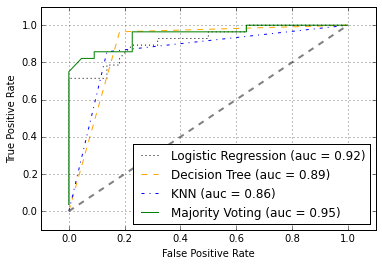

In [17]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip( all_clf, clf_labels, colors, linestyles ):
    # assuming the label of the positive class is 1
    y_pred = clf.fit( X_train, y_train ).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve( y_true = y_test, y_score = y_pred )
    roc_auc = auc( x = fpr, y = tpr )
    plt.plot( fpr, tpr, 
              color = clr, 
              linestyle = ls, 
              label = '%s (auc = %0.2f)' % ( label, roc_auc ) )

plt.legend( loc = 'lower right' )
plt.plot( [0, 1], [0, 1], 
          linestyle = '--', 
          color = 'gray', 
          linewidth = 2 )

plt.xlim( [ -0.1, 1.1 ] )
plt.ylim( [ -0.1, 1.1 ] )
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## sklearn's Majority Voter

In [18]:
from sklearn.ensemble import VotingClassifier
clf_vc = VotingClassifier( estimators = [ ( 'lr', pipe1 ), ( 'dt', clf2 ), ( 'knn', pipe3 ) ], 
                           voting = 'soft' )
clf_vc.fit( X_train, y_train )

VotingClassifier(estimators=[('lr', Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0...ki',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]]))],
         voting='soft', weights=None)

In [19]:
# obtain the parameters name to specify in the grid search
clf_vc.get_params()

{'dt': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': False,
 'dt__random_state': 0,
 'dt__splitter': 'best',
 'estimators': [('lr',
   Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
             penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False)]])),
  ('dt',
   DecisionTree

We can also use it with grid search to obtain the best set of hyperparameters.

In [20]:
from sklearn.grid_search import GridSearchCV

params = { 'dt__max_depth': [1, 2],
           'lr__clf__C': [0.001, 0.1, 100.0] }

grid = GridSearchCV( estimator = clf_vc, 
                     param_grid = params, 
                     cv = 10, scoring = 'roc_auc' )
grid.fit( X_train, y_train )

for params, mean_score, scores in grid.grid_scores_:
    print( "%0.3f+/-%0.2f %r"
           % ( mean_score, scores.std() / 2, params ) ) 

0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 1}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 1}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 1}
0.967+/-0.05 {'lr__clf__C': 0.001, 'dt__max_depth': 2}
0.967+/-0.05 {'lr__clf__C': 0.1, 'dt__max_depth': 2}
1.000+/-0.00 {'lr__clf__C': 100.0, 'dt__max_depth': 2}


In [21]:
print( 'Best parameters: %s' % grid.best_params_ )
print( 'Accuracy: %.2f' % grid.best_score_ )

Best parameters: {'lr__clf__C': 100.0, 'dt__max_depth': 1}
Accuracy: 1.00
